# Tutorial 4: Protein DMS modeling using a biophysical G-P map

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Special imports
import sys
sys.path.insert(0, '../../')
import mavenn

In [2]:
# Standard TensorFlow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant

# Import base class
from mavenn.src.layers.gpmap import GPMapLayer

# Define custom G-P map layer
class OtwinowskiGPMapLayer(GPMapLayer):
    """
    A G-P map representing the thermodynamic model described by
    Otwinowski (2018).
    """

    def __init__(self, *args, **kwargs):
        """Construct layer instance."""

        # Call superclass constructor
        # Sets self.L, self.C, and self.regularizer
        super().__init__(*args, **kwargs)
        
        # Initialize constant parameter for folding energy
        self.theta_f_0 = self.add_weight(name='theta_f_0',
                                         shape=(1,),
                                         trainable=True,
                                         regularizer=self.regularizer)

        # Initialize constant parameter for binding energy
        self.theta_b_0 = self.add_weight(name='theta_b_0',
                                         shape=(1,),
                                         trainable=True,
                                         regularizer=self.regularizer)

        # Initialize additive parameter for folding energy
        self.theta_f_lc = self.add_weight(name='theta_f_lc',
                                          shape=(1, self.L, self.C),
                                          trainable=True,
                                          regularizer=self.regularizer)

        # Initialize additive parameter for binding energy
        self.theta_b_lc = self.add_weight(name='theta_b_lc',
                                          shape=(1, self.L, self.C),
                                          trainable=True,
                                          regularizer=self.regularizer)

    def call(self, x_lc):
        """Compute phi given x."""

        # 1kT = 0.582 kcal/mol at room temperature
        kT = 0.582

        # Reshape input to samples x length x characters
        x_lc = tf.reshape(x_lc, [-1, self.L, self.C])
        
        # Compute Delta G for binding
        Delta_G_b = self.theta_b_0 + \
                    tf.reshape(K.sum(self.theta_b_lc * x_lc, axis=[1, 2]),
                               shape=[-1, 1])
            
        # Compute Delta G for folding
        Delta_G_f = self.theta_f_0 + \
                    tf.reshape(K.sum(self.theta_f_lc * x_lc, axis=[1, 2]),
                               shape=[-1, 1])
        
        # Compute and return fraction folded and bound
        Z = 1+K.exp(-Delta_G_f/kT)+K.exp(-(Delta_G_f+Delta_G_b)/kT)
        p_bf = (K.exp(-(Delta_G_f+Delta_G_b)/kT))/Z
        phi = p_bf #K.log(p_bf)/np.log(2)
        return phi

In [3]:
# Choose dataset
data_name = 'gb1_full_train'
print(f"Loading dataset '{data_name}' ")

# Load datset
data_df = pd.read_csv(f'../datasets/{data_name}_data.csv.gz')

# Get and report sequence length
L = len(data_df.loc[0,'x'])
print(f'Sequence length: {L:d} amino acids')

# Split dataset
trainval_df, test_df = mavenn.split_dataset(data_df)

# Preview trainval_df
print('trainval_df:')
trainval_df

Loading dataset 'gb1_full_train' 
Sequence length: 55 amino acids
Training set   :  530,737 observations ( 100.00%)
Validation set :        0 observations (   0.00%)
Test set       :        0 observations (   0.00%)
-------------------------------------------------
Total dataset  :  530,737 observations ( 100.00%)

trainval_df:


,validation,dist,input_ct,selected_ct,y,x
0,False,2,173,33,-3.145154,AAKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,False,2,18,8,-1.867676,ACKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,False,2,66,2,-5.270800,ADKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,False,2,72,1,-5.979498,AEKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,False,2,69,168,0.481923,AFKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
...,...,...,...,...,...,...
530732,False,2,462,139,-2.515259,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
530733,False,2,317,84,-2.693165,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
530734,False,2,335,77,-2.896589,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
530735,False,2,148,28,-3.150861,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [4]:
# Order the alphabet to match Otwinowski (2018)
alphabet = np.array(list('KRHEDNQTSCGAVLIMPYFW'))
C = len(alphabet)

# define custom gp_map parameters dictionary
gpmap_kwargs = {'L':L,
                'C':C,
                'theta_regularization': 0.0005}

# Create model instance
model = mavenn.Model(L=L,
                     alphabet=alphabet,
                     regression_type='GE',
                     ge_nonlinearity_type='nonlinear',
                     ge_nonlinearity_monotonic=False,
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2,
                     ge_nonlinearity_hidden_nodes=100,
                     eta_regularization=0.0001,
                     gpmap_type='custom',
                     normalize_phi=False,
                     custom_gpmap=OtwinowskiGPMapLayer,
                     gpmap_kwargs=gpmap_kwargs)

In [5]:
# Set False->True to train model
if True:

    # Set training data
    model.set_data(x=trainval_df['x'],
                   y=trainval_df['y'],
                   validation_flags=trainval_df['validation'])

    # Train model
    model.fit(learning_rate=.0005,
              epochs=10,
              batch_size=16,
              early_stopping=False,
              linear_initialization=False,
              verbose=True);

    # Save model to file
    model_name = f'{data_name}_thermodynamic_model'
    model.save(model_name)

N = 530,737 observations set as training data.
Using 0.0% for validation.
Data shuffled.
Time to set data: 9.07 sec.


Epoch 1/10
33172/33172 [==============================] - 58s 2ms/step - loss: -1.3136 - I_var: 1.8892
Epoch 2/10
33172/33172 [==============================] - 57s 2ms/step - loss: -3.6130 - I_var: 2.0997
Epoch 3/10
33172/33172 [==============================] - 57s 2ms/step - loss: -3.6490 - I_var: 2.1038
Epoch 4/10
33172/33172 [==============================] - 56s 2ms/step - loss: -3.6456 - I_var: 2.1037
Epoch 5/10
33172/33172 [==============================] - 57s 2ms/step - loss: -3.6602 - I_var: 2.1052
Epoch 6/10
33172/33172 [==============================] - 57s 2ms/step - loss: -3.7077 - I_var: 2.1098
Epoch 7/10
33172/33172 [==============================] - 60s 2ms/step - loss: -3.7412 - I_var: 2.1132
Epoch 8/10
33172/33172 [==============================] - 56s 2ms/step - loss: -3.7956 - I_var: 2.1187
Epoch 9/10
33172/33172 [==============================] - 56s 2ms/step - loss: -3.9144 - I_var: 2.1301
Epoch 10/10
33172/33172 [==============================] - 56s 2ms/step -

In [6]:
# Retrieve G-P map parameter dict and view dict keys
theta_dict = model.layer_gpmap.get_params()
theta_dict.keys()

dict_keys(['theta_f_0', 'theta_b_0', 'theta_f_lc', 'theta_b_lc'])

In [7]:
# Get the wild-type GB1 sequence
wt_seq = model.x_stats['consensus_seq']

# Convert this to a one-hot encoded matrix of size LxC
from mavenn.src.utils import _x_to_mat
x_lc_wt = _x_to_mat(wt_seq, model.alphabet)

# Subtract wild-type character value from parameters at each position
ddG_b_mat_mavenn = theta_dict['theta_b_lc'] - np.sum(x_lc_wt*theta_dict['theta_b_lc'], axis=1)[:,np.newaxis]
ddG_f_mat_mavenn = theta_dict['theta_f_lc'] - np.sum(x_lc_wt*theta_dict['theta_f_lc'], axis=1)[:,np.newaxis]

# Load Otwinowski parameters form file
dG_b_otwinowski_df = pd.read_csv('../../mavenn/examples/datasets/raw/otwinowski_gb_data.csv.gz', index_col=[0]).T.reset_index(drop=True)[model.alphabet]
dG_f_otwinowski_df = pd.read_csv('../../mavenn/examples/datasets/raw/otwinowski_gf_data.csv.gz', index_col=[0]).T.reset_index(drop=True)[model.alphabet]

# Compute ddG matrices for Otwinowski
ddG_b_mat_otwinowski = dG_b_otwinowski_df.values - \
                       np.sum(x_lc_wt*dG_b_otwinowski_df.values, axis=1)[:,np.newaxis]
ddG_f_mat_otwinowski = dG_f_otwinowski_df.values - \
                       np.sum(x_lc_wt*dG_f_otwinowski_df.values, axis=1)[:,np.newaxis]


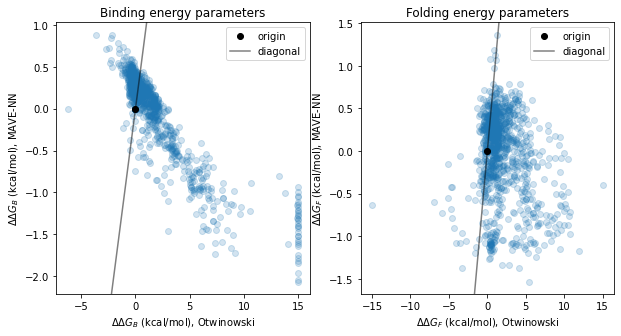

In [8]:
# Set plotting routine
def draw(ax, x, y, ddG_var, title):
    ax.scatter(x, y, alpha=.2)
    xlim = ax.get_xlim()
    ax.autoscale(False)
    ax.plot(0,0,'ok', label='origin')
    ax.plot(xlim, xlim, '-k', alpha=.5, label='diagonal')
    ax.set_xlabel(f'{ddG_var} (kcal/mol), Otwinowski')
    ax.set_ylabel(f'{ddG_var} (kcal/mol), MAVE-NN')
    ax.set_title(title)
    ax.legend()

# Create figure and make plots
fig, axs = plt.subplots(1,2, figsize=(10,5))
draw(ax=axs[0],
     x=ddG_b_mat_otwinowski.ravel(),
     y=ddG_b_mat_mavenn.ravel(),
     ddG_var='$\Delta \Delta G_B$',
     title='Binding energy parameters')
draw(ax=axs[1],
     x=ddG_f_mat_otwinowski.ravel(),
     y=ddG_f_mat_mavenn.ravel(),
     ddG_var='$\Delta \Delta G_F$',
     title='Folding energy parameters')


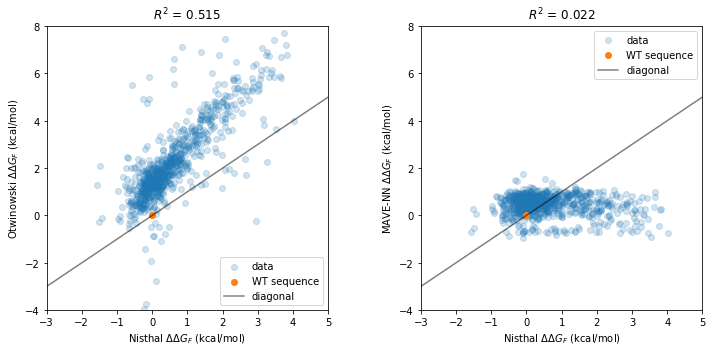

In [9]:
# Load Nisthal data
nisthal_df = mavenn.load_example_dataset('nisthal')
nisthal_df.set_index('x', inplace=True)

# Get Nisthal folding energies relative to WT
dG_f_nisthal = nisthal_df['y']
dG_f_wt_nisthal = dG_f_nisthal[wt_seq]
ddG_f_nisthal = dG_f_nisthal - dG_f_wt_nisthal

# Get MAVE-NN folding energies relative to WT
x_nisthal = nisthal_df.index.values
x_nisthal_ohe = mavenn.src.utils.x_to_ohe(x=x_nisthal,
                                          alphabet=model.alphabet)
ddG_f_vec = ddG_f_mat_mavenn.ravel().reshape([1,-1])
ddG_f_mavenn = np.sum(ddG_f_vec*x_nisthal_ohe, axis=1)

# Get Otwinowski folding energies relative to WT
ddG_f_vec_otwinowski = ddG_f_mat_otwinowski.ravel().reshape([1,-1])
ddG_f_otwinowski = np.sum(ddG_f_vec_otwinowski*x_nisthal_ohe, axis=1)

# Define plotting routine
def draw(ax, y, model_name):
    Rsq = np.corrcoef(ddG_f_nisthal, y)[0, 1]**2
    ax.scatter(ddG_f_nisthal, y, alpha=.2, label='data')
    ax.scatter(0,0, label='WT sequence')
    xlim = [-3,5]
    ax.set_xlim(xlim)
    ax.set_ylim([-4,8])
    ax.plot(xlim, xlim, color='k', alpha=.5, label='diagonal')
    ax.set_xlabel(f'Nisthal $\Delta \Delta G_F$ (kcal/mol)')
    ax.set_ylabel(f'{model_name} $\Delta \Delta G_F$ (kcal/mol)')
    ax.set_title(f'$R^2$ = {Rsq:.3f}')
    ax.legend()

# Make figure
fig, axs = plt.subplots(1,2,figsize=[10,5])
draw(ax=axs[0],
     y=ddG_f_otwinowski,
     model_name='Otwinowski')
draw(ax=axs[1],
     y=ddG_f_mavenn,
     model_name='MAVE-NN')

fig.tight_layout(w_pad=5)